# Regressions

In [1]:
import time
import datetime
import bz2
from dateutil.relativedelta import relativedelta, MO

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\apps\anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['MO']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
df = pd.read_csv('data_ML_25_05.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,close,close_change,open,high,low,volume,bb_bbh,bb_bbl,bb_bbm,ATR_10,...,ROCI_40,ROCI_60,ROCI_120,Vortex_diff,Vortex_neg,Vortex_pos,ichimoku_a,ichimoku_b,ichimoku_bl,ichimoku_cl
date,,,,,,,,,,,,,,,,,,,,,
2015-01-19,1.15947,1,1.15614,1.16388,1.15514,141004,1.225656,1.149432,1.187544,0.009608,...,0.000000,0.000000,0.000000,-0.412351,0.876489,0.464137,1.175315,1.18409,1.184090,1.166540
2015-06-08,1.12800,1,1.11023,1.13068,1.10842,220017,1.139031,1.079038,1.109034,0.014026,...,5.179729,4.162819,-2.714171,0.011417,0.978159,0.989576,1.113830,1.09936,1.114305,1.113355
2015-06-09,1.12926,1,1.12802,1.13454,1.12140,224134,1.135281,1.081274,1.108277,0.013938,...,4.427676,5.162876,-2.189617,0.071010,0.967493,1.038503,1.113830,1.09936,1.114305,1.113355
2015-06-10,1.13099,1,1.12926,1.13865,1.12600,246733,1.134962,1.081451,1.108207,0.013809,...,4.041175,5.017875,-2.624261,0.027184,0.995233,1.022417,1.113997,1.09936,1.114305,1.113690
2015-06-11,1.12458,0,1.13099,1.13315,1.11820,203152,1.136311,1.081135,1.108723,0.013923,...,3.500069,3.460077,-0.889245,-0.028576,1.015807,0.987231,1.114712,1.09936,1.114305,1.115120


## Data preparation

In [3]:
def classification_results(y_test, y_pred):    # Classification metrics
    #print("Kross validation score=", scores[-1])
    #print("Mean=", np.mean(scores[-1]))
    
    print("accuracy", accuracy_score(y_test, y_pred)) 
    print("precision", precision_score(y_test,y_pred))
    print("recall", recall_score(y_test,y_pred))

In [4]:
train_part = int(len(df.close)*0.8)
test_part = len(df.close) - train_part
#train_part

In [5]:
def make_dataset(df, train_part, test_part,d_type ="test"):
    X = df.copy(deep=True)
    X.drop(['close_change', 'close'],axis=1, inplace= True)
    if d_type == "test":
        X.drop(X.index[:train_part],inplace= True)
    else : X.drop(X.index[train_part:(train_part+test_part)],inplace= True)
    X = StandardScaler().fit_transform(X)
    return X

In [6]:
X_test = make_dataset(df, train_part, test_part,d_type ="test")
X_train = make_dataset(df, train_part, test_part,d_type ="train")
y_train = df['close_change'][:-test_part]
y_test = df['close_change'][-test_part:]

In [7]:
tscv = TimeSeriesSplit(n_splits=10)

In [8]:
def sell(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df,i, train_part):
    last_deal = 1 #продажа
    revenue = revenue + (df['close'][train_part + i] - last_price)*1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] > last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit+(df['close'][train_part + i] - last_price)*1000
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [9]:
def buy(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df, i, train_part):
    last_deal = 0
    revenue = revenue + (last_price - df['close'][train_part + i]) *1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] < last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit + (last_price - df['close'][train_part + i])*1000 
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [10]:
def trade(df, y_pred, train_part, pred_limit=20):
    
    profit = 0
    revenue = 0
    successful_deals = 0
    deals_overall = 0
    actions_list = []
    revenue_list = []
    last_price = 0
    last_deal = 2
    
    for i in range(len(y_pred[:pred_limit])):
        pred = y_pred[i] 
        if last_deal == 2:  #смотрим на первое предсказание
            last_price = df['close_change'][train_part + i]
            if pred == 0:  #если ожидаем, что цена пойдет вверх
                last_deal = 1  #последняя сделка - покупка
            else: 
                last_deal = 0
        if (last_deal == 0 and pred == 0): #если есть чем торговать (последняя -покупка) и ожидаем уменьшения цены
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = sell(last_deal, 
                                                                                          revenue, revenue_list, successful_deals, profit, last_price, df, i,train_part)
            actions_list.append(1)
            deals_overall +=1
            continue
        if (last_deal == 1 and pred == 1):
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = buy(last_deal, 
                                                                                         revenue, revenue_list, successful_deals, profit, last_price, df, i, train_part)
            actions_list.append(0)            
            deals_overall +=1
            continue
        actions_list.append(-1)
    return revenue, revenue_list, successful_deals, deals_overall, profit, actions_list

## Logistic Regression 

In [11]:
param_search = { 
    'C' : [0.75 ,0.5, 0.1, 0.01 ,0.005],
    'penalty' : ['l2'], # ['l1','l2', 'elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100000]
}

In [12]:
model = LogisticRegression()
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [13]:
best_model.get_params()

{'C': 0.75,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
# scores.append(cross_val_score(estimator=model, X=X_train,y=y_train,cv=cv,scoring="roc_auc"))

In [15]:
best_model.get_params()

{'C': 0.75,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [16]:
#model = LogisticRegression(C=best_C).fit(X_train, y_train)

result = best_model.predict_proba(X_test)
y_pred =  best_model.predict(X_test)

In [17]:
result_pd = pd.Series(result[:, 1])
result_pd.describe()

count    373.000000
mean       0.503592
std        0.200047
min        0.007537
25%        0.369458
50%        0.490335
75%        0.659884
max        0.979387
dtype: float64

In [18]:
best_model.score(X_train, y_train)

0.7788978494623656

In [19]:
#regression_results(y_test, y_pred)
print("accuracy", accuracy_score(y_test, y_pred)) 
print("precision", precision_score(y_test,y_pred))
print("recall", recall_score(y_test,y_pred))

accuracy 0.7479892761394102
precision 0.8089887640449438
recall 0.7058823529411765


In [20]:
pred_limit = 80
revenue, revenue_list, successful_deals, deals_overall, profit, actions_list = trade(df, y_pred, train_part, pred_limit)

In [21]:
print("revenue", round(revenue,4),";\tprofit", round(profit,4))
print("successful deals", successful_deals, ";\toveral dealls:", deals_overall)
print("% of succsess", round(successful_deals*100/deals_overall,4))
print("deals were made on ", round(deals_overall*100/len(y_pred[:pred_limit]),4),"% of",len(y_pred[:pred_limit]), "traiding days")

revenue 1123.22 ;	profit 1193.07
successful deals 9 ;	overal dealls: 22
% of succsess 40.9091
deals were made on  27.5 % of 80 traiding days


In [22]:
days_plot = []
revenue_plot = []
success_plot = []
deals_overall_plot = []
for i in range(10, test_part, 10):
    y_pred =  best_model.predict(X_test)
    X_train_cycle = make_dataset(df, train_part, i, d_type ="train")
    y_pred_cycle =  best_model.predict(X_train_cycle)
    revenue, revenue_list, successful_deals, deals_overall, profit, actions_list = trade(df, y_pred_cycle, train_part, i)
    days_plot.append(i)
    revenue_plot.append(revenue)
    success_plot.append(round(deals_overall*100/i,2))
    deals_overall_plot.append(round(deals_overall*100/i,2))

d = {'days': days_plot, 'revunue': revenue_plot, 'proftitable deals %' : success_plot, 'overall deals %' : deals_overall_plot}
future = pd.DataFrame(data=d)
future.set_index('days', inplace=True)
#future

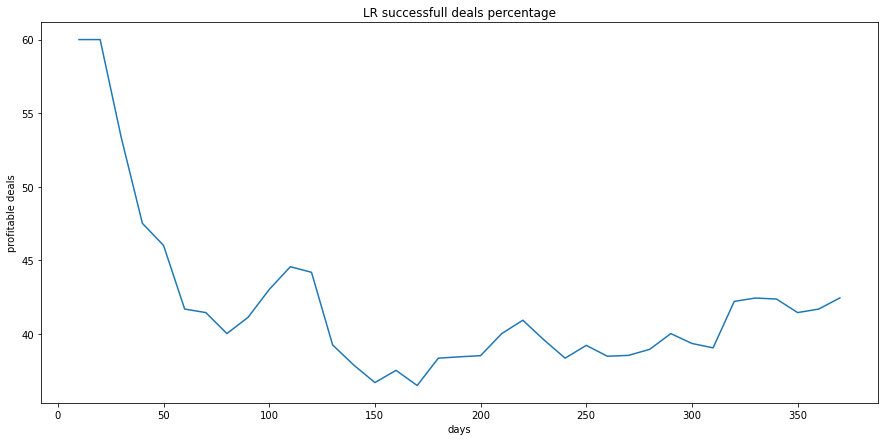

In [23]:
plt.figure(figsize(15,7))

future['proftitable deals %'].plot()
plt.ylabel('profitable deals')
plt.title('LR successfull deals percentage')
pylab.show()

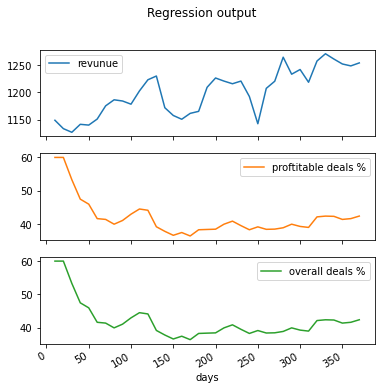

In [25]:
#plt.figure(figsize(15,7))
#plt.title('Regression putput')
future.plot(subplots=True, figsize=(6, 6), title='Regression output');
